Install the required libraries

In [1]:
'''
!pip install --upgrade nltk
!pip install wordcloud
!pip install textblob
'''

In [2]:
import ibm_db
import ibm_db_dbi
import os
import re
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
nltk.download("stopwords")
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import subprocess


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gadda\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
#importing file which sets env variable
subprocess.call("./settings.sh", shell = True)

In [3]:
consumer_key = os.environ['CONSUMER_KEY']
consumer_secret = os.environ['CONSUMER_SECRET']
access_token = os.environ['ACCESS_TOKEN']
access_token_secret = os.environ['ACCESS_TOKEN_SECRET']
password = os.environ['PASSWORD']


dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net"            # e.g.: "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_port = "50000"                    # e.g. "50000" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_uid = os.environ['DSN_ID']
dsn_pwd = os.environ['DSN_PWD']

In [4]:
#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

# try:
#     conn = ibm_db.connect(dsn, "", "")
#     print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

# except:
#     print ("Unable to connect: ", ibm_db.conn_errormsg() )


In [7]:
def DB2Connect(query):
    """
    Connects to database and extracts
    raw tweets and any other columns we
    need
    Parameters:
    ----------------
    arg1: string: SQL query
    Returns: Pandas Dataframe
    ----------------
    """

    try:
        con = ibm_db.connect(dsn, "", "")
        conn = ibm_db_dbi.Connection(con)   
        cur = conn.cursor()
        cur.execute(query)
        data = cur.fetchall()
        # store in dataframe
        df = pd.DataFrame(data,columns = ['date', 'tweet'])

    except :
        print(ibm_db.conn_errormsg())

    cur.close()
    conn.close()

    return df

class TweetObject():

#     def __init__(self,dsn):
#         self.dsn = dsn
    
    
    def clean_tweets(self, df):
        """
        Takes raw tweets and cleans them
        so we can carry out analysis
        remove stopwords, punctuation,
        lower case, html, emoticons.
        This will be done using Regex
        ? means option so colou?r matches
        both color and colour.
        """

        # Do some text preprocessing
        stopword_list = stopwords.words('english')
        ps = PorterStemmer()
        df["clean_tweets"] = None
        df['len'] = None
        for i in range(0,len(df['tweet'])):
        # get rid of anythin that isnt a letter
            exclusion_list = ['[^a-zA-Z]','rt', 'http', 'co', 'RT']
            exclusions = '|'.join(exclusion_list)
            text = re.sub(exclusions, ' ' , df['tweet'][i])
            text = text.lower()
            words = text.split()
            words = [word for word in words if not word in stopword_list]
            # only use stem of word
            #words = [ps.stem(word) for word in words]
            df['clean_tweets'][i] = ' '.join(words)


        # Create column with data length
            #df['len'] = np.array([len(tweet) for tweet in data["clean_tweets"]])
        return df

    def sentiment(self, tweet):
        """
        This function calculates sentiment
        on our cleaned tweets.
        Uses textblob to calculate polarity.
        Parameters:
        ----------------
        arg1: takes in a tweet (row of dataframe)
        """

        # need to improce
        analysis = TextBlob(tweet)
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
        
    def save_to_csv(self, df):
        """
        Save cleaned data to a csv for further
        analysis.
        Parameters:
        ----------------
        arg1: Pandas dataframe
        """
        try:
            df.to_csv("D:/Twitter/clean_tweets.csv")
            print("\n")
            print("csv successfully saved. \n")

        except Exception as e:
            print(e)

    def word_cloud(self, df):
        plt.subplots(figsize = (12,10))
        wordcloud = WordCloud(
                    background_color = 'white',
                    width = 1000,
                    height = 800).generate(" ".join(df['clean_tweets']))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()

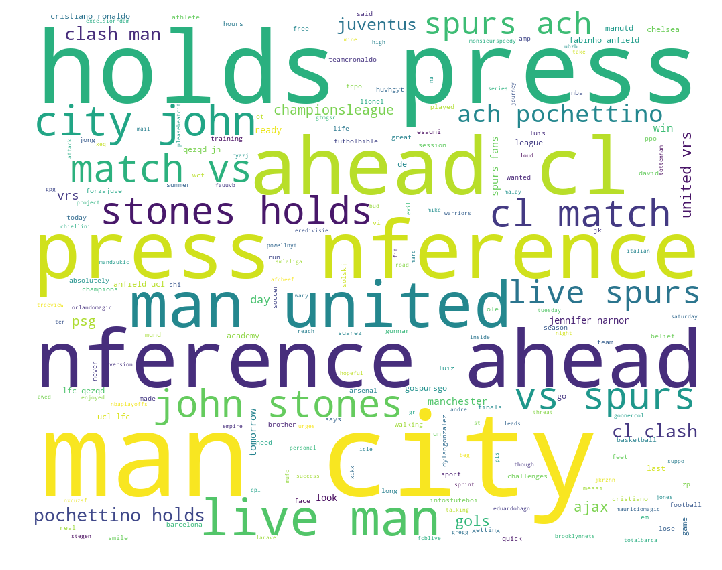



csv successfully saved. 

percentage of positive tweets: 66.66666666666666%
percentage of negative tweets: 4.444444444444445%
percentage of neutral tweets: 28.888888888888886%


In [8]:

if __name__ == '__main__':

    t = TweetObject()
    data  = DB2Connect("SELECT created_at, tweet from FOOTBALL")
    #data  = t.DB2Connect("SELECT created_at, tweet from FOOTBALL")
    data = t.clean_tweets(data)
    data['Sentiment'] = np.array([t.sentiment(x) for x in data['clean_tweets']])
    t.word_cloud(data)
    t.save_to_csv(data)

    pos_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] > 0]
    neg_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] < 0]
    neu_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] == 0]

    #Print results
    print("percentage of positive tweets: {}%".format(100*(len(pos_tweets)/len(data['clean_tweets']))))
    print("percentage of negative tweets: {}%".format(100*(len(neg_tweets)/len(data['clean_tweets']))))
    print("percentage of neutral tweets: {}%".format(100*(len(neu_tweets)/len(data['clean_tweets']))))
